In [1]:
# Obtém arquivo ajustado com os dados da rede de metrô de SP:
import pandas as pd

df_metro_sp = pd.read_csv('sp_transporte_ajustado.csv', delimiter=';') 

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Dicionário de cores com base no campo _linhaId para atribuir uma cor para cada linha
# O valor é uma string que representa o nome da cor em HTML/CSS
cores = {1:'blue', #'1-Azul'
         2:'green', #'2-Verde'
         3:'red', #'3-Vermelha'
         4:'darkmagenta', #'7-Rubi (Luz-Francisco Morato-Jundiaí)'
         5:'silver', #'8-Diamante (Júlio Prestes-Itapevi-Amador Bueno)'
         6:'mediumseagreen', #'9-Esmeralda (Osasco-Grajaú)'
         7:'darkcyan', #'10-Turquesa (Luz-Rio Grande da Serra)'
         8:'tomato', #'11-Coral-Expresso Leste (Luz-Guaianazes)'
         9:'darkblue', #'12-Safira (Brás-Calmon Viana)'
         10:'slateblue', #'5-Lilás'
         11:'royalblue', #'EMTU'
         14:'tomato', #11-Coral (Guaianazes-Estudantes)'
         17:'gold', #'4-Amarela'
         18:'slategray', #'15-Prata'             
         20:'limegreen', #'13-Jade'
         'baldeacao':'black' # Para baldeações
        }
# Traço padrão para as arestas
width_maior = 8
#width_maior = 3
width_menor = 3

def construir_grafo_metro(df_metro_sp):
    '''
    Constrói o grafo das estações do metrô de SP com base no dataframe fornecido
    Recebe como parâmetro:
        - Dataframe contendo as estações de SP
    Retorna:
        - Grafo networkx com as estações
    '''
            
    # Ordena o dataframe pela coluna id
    df_metro_sp.sort_values(by=['id'], inplace=True)
    
    # Incializa o grafo
    grafo_metro = nx.Graph()    
    
    # Obtém lista de linhas do metrô
    linhas = df_metro_sp['_linhaId'].unique()    
    
    # Para cada linha
    for linha in linhas:
        
        # Se for a linha EMTU, o traço será mais fino
        traco_aresta = width_maior
        if linha == 11:
            traco_aresta = width_menor        
        
        # Obtém as estações
        estacoes = df_metro_sp[df_metro_sp['_linhaId'] == linha].to_dict(orient='records')        
        id_estacao_anterior = None
            
        # Para cada estação, cria o vértice, a conexão com a estação anterior e baldeações, se tiver
        for i in range(len(estacoes)):
            estacao = estacoes[i]
            id_estacao = estacao.get('id')
            
            # Verifica se o registro realmente possui id
            if pd.isna(id_estacao):
                continue
            
            # Garante que o id será um número:
            id_estacao = int(id_estacao)
            
            # Verifica se o registro possui baldeação
            tem_baldeacao = False
            baldeacoes = []
            if not pd.isna(estacao['baldeacao']):
                tem_baldeacao = True
                baldeacoes = estacao['baldeacao'].split(' ')            
            
            # Cria o nó no grafo
            adiciona_no(grafo_metro, estacao, tem_baldeacao, linha)
            
            # Cria a aresta/ligação com o nó anterior
            if id_estacao_anterior != None:
                grafo_metro.add_edge(id_estacao_anterior, id_estacao, edge_color = linha, width = traco_aresta)
                
            # Cria aresta/ligação para cada baldeação
            if tem_baldeacao:
                for baldeaco in baldeacoes:
                    grafo_metro.add_edge(id_estacao, int(baldeaco), edge_color = 'baldeacao', width = width_menor)
                    
            id_estacao_anterior = id_estacao
    
    # Ajusta estações Ferrazópolis e Jabaquara do EMTU    
    #Ferrazópolis
    ferrazopolis_id = int(2009)
    df_metro_sp.loc[205, 'id'] = ferrazopolis_id    
    adiciona_no(grafo_metro, df_metro_sp.loc[205].to_dict(), False, 11)     
    grafo_metro.add_edge(ferrazopolis_id, 2005, edge_color = 11, width = width_menor)
    
    #Jabaquara
    jabaquara_emtu_id = 2010    
    df_metro_sp.loc[206, 'id'] = jabaquara_emtu_id
    adiciona_no(grafo_metro, df_metro_sp.loc[206].to_dict(), True, 11)     
    grafo_metro.add_edge(jabaquara_emtu_id, 2003, edge_color = 'baldeacao', width = width_menor)
    grafo_metro.add_edge(jabaquara_emtu_id, 123, edge_color = 'baldeacao', width = width_menor)
        
    return grafo_metro


def adiciona_no(grafo, estacao, tem_baldeacao, cor):
    '''
    Método auxiliar para adicionar uma estação como nó no grafo fornecido
    Recebe como parâmetros:
        - grafo: grafo onde o nó será adicionado
        - estacao: dicionário contendo informações da estação que será adicionada como nó        
        - tem_baldeacao: booleano que indica se a estação faz conexão com a estação de outra linha    
    '''
    
    estacao_id = int(estacao['id'])
    
    grafo.add_node(estacao_id,                    
                   nome = estacao['_nome'], 
                   linha = estacao['_linha'],
                   tipo = estacao['_tipo'],
                   pos_x = int(estacao['pos_x']),
                   pos_y = int(estacao['pos_y']),
                   tem_baldeacao = tem_baldeacao,
                   node_color = cor)    
    
    
    
grafo_metro = construir_grafo_metro(df_metro_sp)

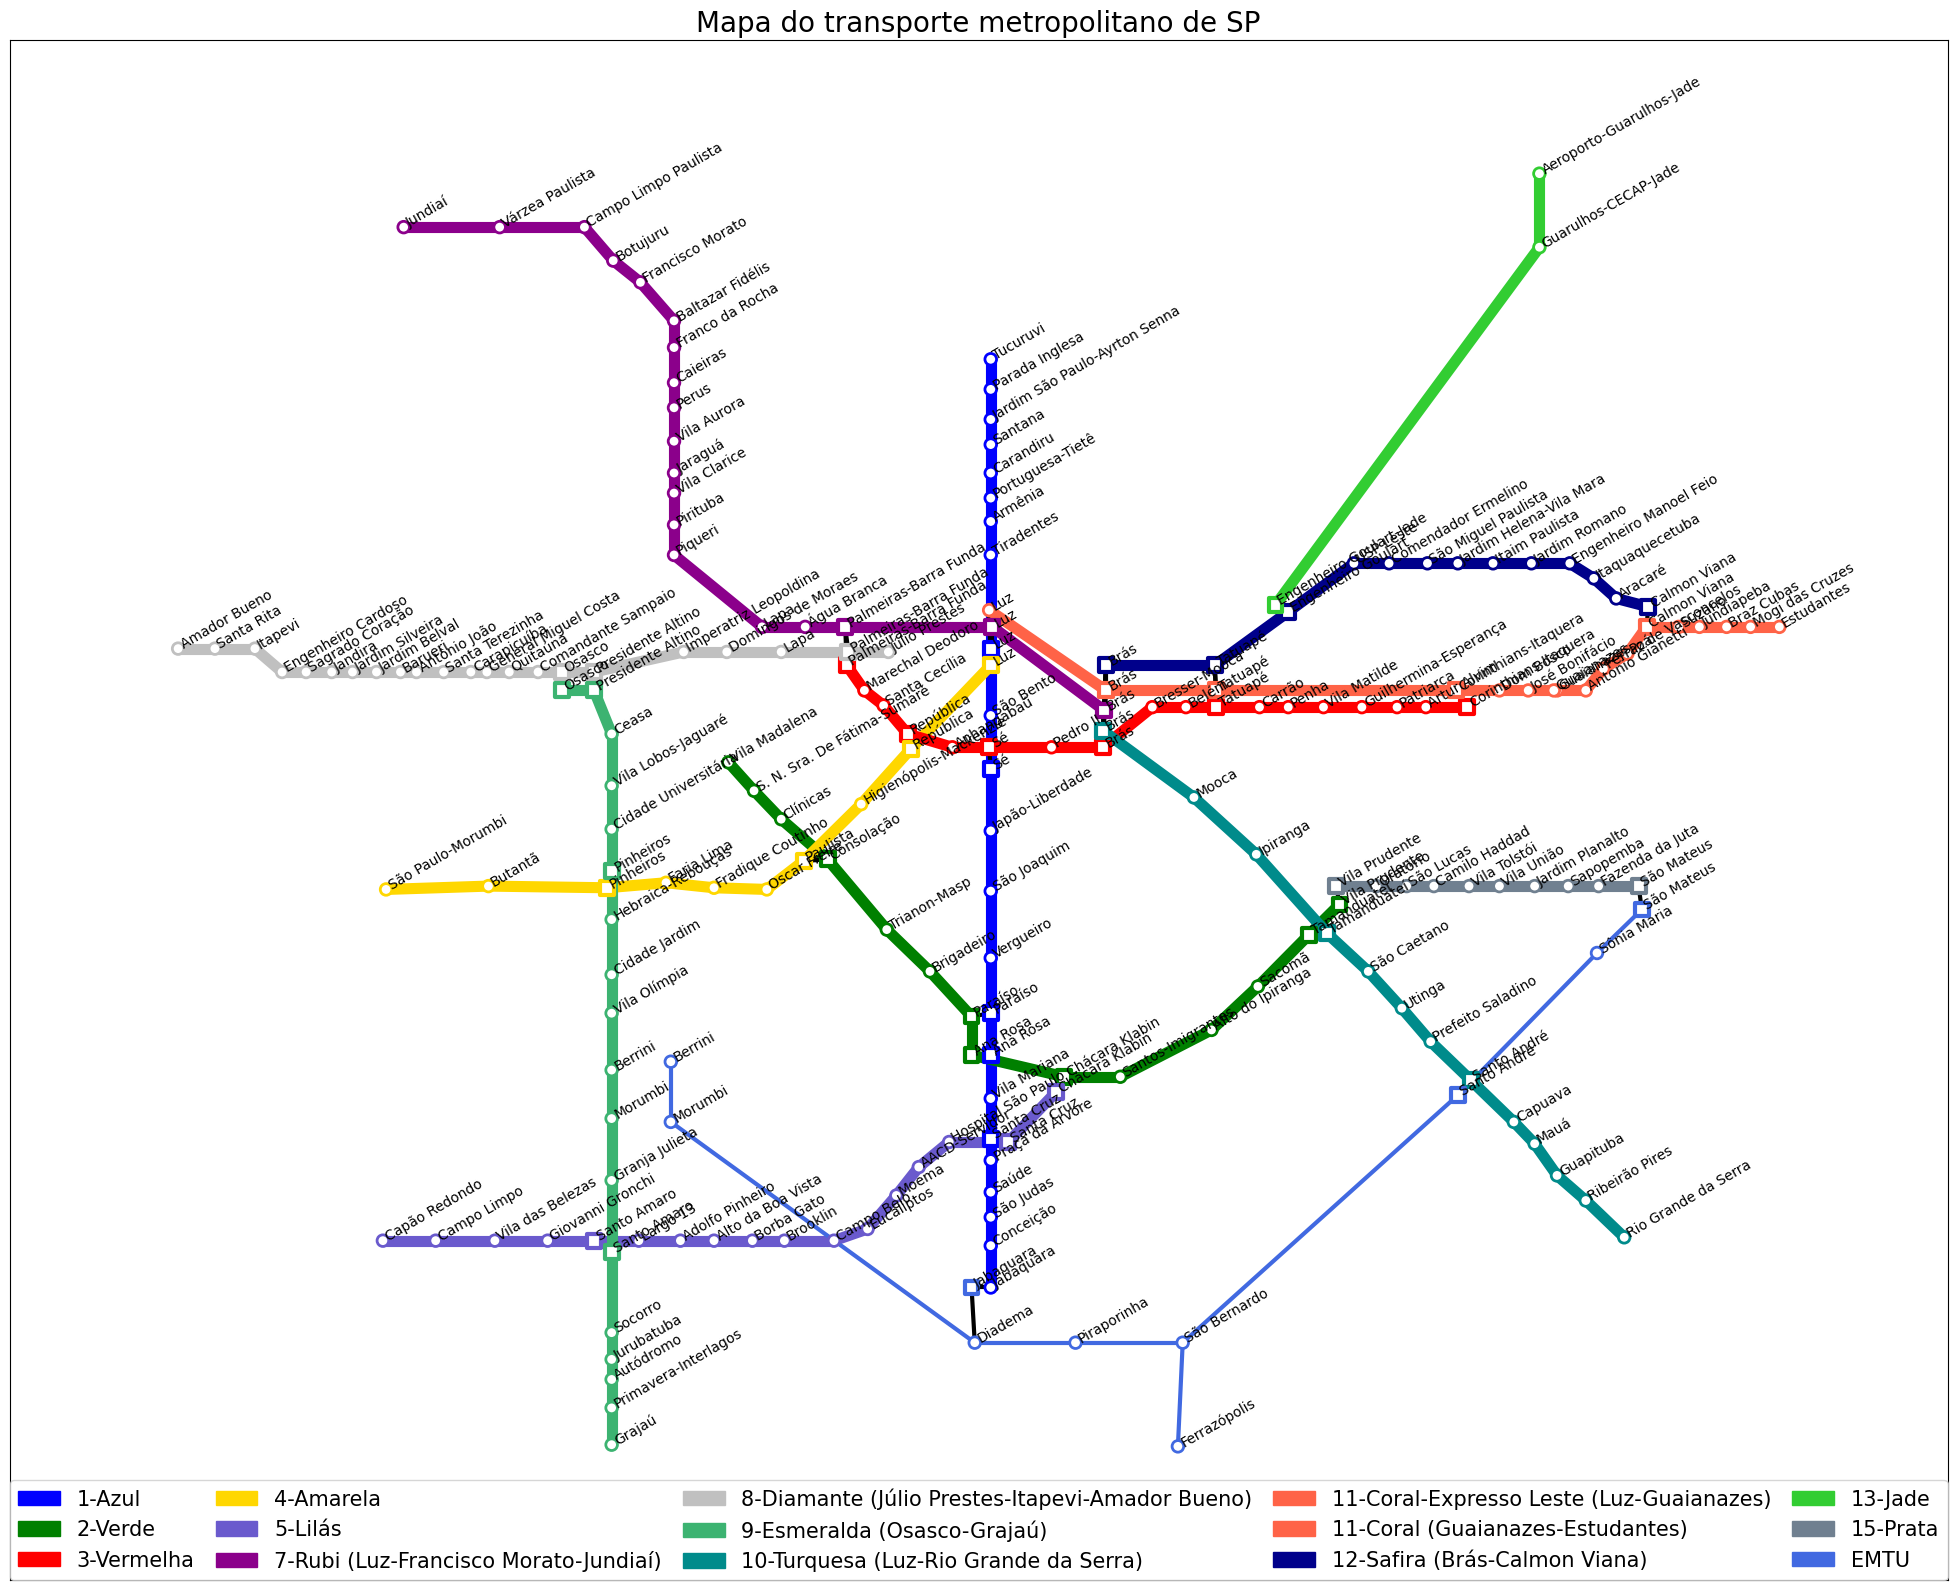

In [3]:
def exibir_grafo(grafo):
    '''
    Constrói e exibe o gráfico que representa o grafo fornecido
    Recebe como parâmetro:
        - Grafo que será desenhado    
    '''

    # Define o tamanho da imagem
    fig, ax = plt.subplots(figsize=(25, 20))    
    
    # Gera a posição do grafo e obtém as coordenadas x,y dos nós
    pos = nx.spring_layout(grafo)    
    for no, no_dados in grafo.nodes(data=True):
        if no != None and no_dados.get('pos_x') != None and no_dados.get('pos_y') != None:
            pos[no] = np.array([no_dados.get('pos_x'), no_dados.get('pos_y')])

    # Obtém todos os nós do grafo
    nos = grafo.nodes(data=True)
    
    # Desenha os nós que não têm baldeação
    nos_sem_baldeacao = [no for no in filter(lambda x: x[1].get('tem_baldeacao')==False, nos)]
    node_list = [no[0] for no in nos_sem_baldeacao]
    node_colors = [cores[no[1].get('node_color')] for no in nos_sem_baldeacao]
    nx.draw_networkx_nodes(
        grafo, 
        pos, 
        ax = ax,
        nodelist = node_list,
        node_shape = 'o',        
        node_size = 70,
        edgecolors = node_colors,                
        node_color = 'white',
        #node_color = node_colors,
        linewidths = 2,        
    ) 
    
    # Desenha os nós com baldeação
    nos_com_baldeacao = [no for no in filter(lambda x: x[1].get('tem_baldeacao')==True, nos)]
    node_list = [no[0] for no in nos_com_baldeacao]
    node_colors = [cores[no[1].get('node_color')] for no in nos_com_baldeacao]    
    nx.draw_networkx_nodes(
        grafo, 
        pos, 
        nodelist = node_list,
        node_size = 100, 
        node_color = 'white',
        edgecolors = node_colors,
        linewidths = 3,
        node_shape = 's',        
        ax = ax
    ) 
            
    # Obtém as cores e a grossura das arestas e as desenha
    edge_colors = [cores[grafo[u][v].get('edge_color')] for u,v in grafo.edges()]        
    edge_widths = [grafo[u][v].get('width') for u,v in grafo.edges()]        
    nx.draw_networkx_edges(
        grafo, 
        pos,
        edge_color = edge_colors,
        width = edge_widths,
        alpha = 1
    )
    
    
    # Obtém as labels e as rotaciona
    labels = nx.get_node_attributes(grafo, 'nome')    
    text = nx.draw_networkx_labels(
        grafo, 
        pos, 
        labels = labels,
        font_size = 10,
        horizontalalignment = 'left',
        verticalalignment = 'baseline'
    )
    for no, t in text.items(): 
        t.set_rotation(30)
        
    # Adiciona legendas
    linhas = []
    for _, no in sorted(nos):
        cor_id = no.get('node_color')  
        nome_linha = no.get('linha')
        linha = cor_id, nome_linha
        
        if linha not in linhas:
            linhas.append(linha)
        
    legendas = [mpatches.Patch(color=cores[linha[0]], label=linha[1]) for linha in linhas]    
    #ax.legend(handles=legendas, fontsize=15, loc='lower right')
    ax.legend(bbox_to_anchor = (0, 0, 1, 1), 
              loc = 'lower left',
              ncol = 5, 
              mode = "expand", 
              borderaxespad = 0., 
              handles = legendas, 
              fontsize = 15)
    
    plt.axis('on')
    plt.title('Mapa do transporte metropolitano de SP', fontsize = 20)    
    plt.show()            

exibir_grafo(grafo_metro)

In [4]:
def listar_todas_estacoes(grafo):
    '''
    Lista todas as estações mapeadas no grafo recebido como parâmetro
    '''
    # Obtém nós do grafo ordenados por id
    nos = sorted(grafo.nodes(data=True))
    
    for no in nos:
        linha = no[1].get('linha')
        nome = no[1].get('nome')
        print(f'{no[0]}: Linha {linha} - Estação {nome}')

        
listar_todas_estacoes(grafo_metro)

101: Linha 1-Azul - Estação Tucuruvi
102: Linha 1-Azul - Estação Parada Inglesa
103: Linha 1-Azul - Estação Jardim São Paulo-Ayrton Senna
104: Linha 1-Azul - Estação Santana
105: Linha 1-Azul - Estação Carandiru
106: Linha 1-Azul - Estação Portuguesa-Tietê
107: Linha 1-Azul - Estação Armênia
108: Linha 1-Azul - Estação Tiradentes
109: Linha 1-Azul - Estação Luz
110: Linha 1-Azul - Estação São Bento
111: Linha 1-Azul - Estação Sé
112: Linha 1-Azul - Estação Japão-Liberdade
113: Linha 1-Azul - Estação São Joaquim
114: Linha 1-Azul - Estação Vergueiro
115: Linha 1-Azul - Estação Paraíso
116: Linha 1-Azul - Estação Ana Rosa
117: Linha 1-Azul - Estação Vila Mariana
118: Linha 1-Azul - Estação Santa Cruz
119: Linha 1-Azul - Estação Praça da Árvore
120: Linha 1-Azul - Estação Saúde
121: Linha 1-Azul - Estação São Judas
122: Linha 1-Azul - Estação Conceição
123: Linha 1-Azul - Estação Jabaquara
201: Linha 2-Verde - Estação Vila Madalena
202: Linha 2-Verde - Estação S. N. Sra. De Fátima-Sumaré


In [5]:
def encontrar_melhor_caminho(grafo, partida, destino):
    '''
    Encontra o melhor caminho entre dois nós
    Recebe como parâmetros:
        - Grafo contendo as estações de SP
        - Estação de partida (id ou nome)
        - Estação de destino (id ou nome)
    '''

    # Tenta converter as estações em número, caso tenha recebido id
    # Senão, procura o nó que contém o nome da estação
    if isinstance(partida, str):
        if partida.isdigit():
            no_partida = int(partida)
        else:
            no_partida = [x for x,y in grafo.nodes(data=True) if y.get('nome')==partida][0]
    else:
        no_partida = partida

    if isinstance(destino, str):
        if destino.isdigit():
            no_destino = int(destino)
        else:
            no_destino = [x for x,y in grafo.nodes(data=True) if y.get('nome')==destino][0]    
    else:
        no_destino = destino
            
    caminho_mais_curto = nx.shortest_path(grafo, no_partida, no_destino)    
    descrever_rota(grafo, caminho_mais_curto)

    
    
def descrever_rota(grafo, caminho = []):
    '''
    Descreve o trajeto recebido
    Recebe como parâmetros:
        - grafo: Grafo contendo as estações de SP
        - caminho: lista com os nós do caminho a ser descrito 
    '''
    if len(caminho) == 0:
        print('Rota não encontrada.')
        return
    
    if len(caminho) == 1:
        print('Você já está na estação de destino.')
        return
    
    origem = grafo.nodes[caminho[0]]
    origem_nome = origem.get("nome")
    print(f'Origem: {origem_nome}')  
    
    destino = grafo.nodes[caminho[-1]]
    destino_nome = destino.get("nome")    
    print(f'Destino: {destino.get("nome")}')  
    
    print('\nRota resumida:')
    print(caminho)
    ultimo_nome = ''
    for i in range(len(caminho) - 1):
        nome = grafo.nodes[caminho[i]].get('nome')
        # Se a estação tiver o mesmo nome, não repete
        if ultimo_nome != nome:
            print(nome, end=' >>> ')
            ultimo_nome = nome
    print(grafo.nodes[caminho[-1]].get('nome'))
        
    
    print('\nRota detalhada:')
    
    contador = 0
    i = 0
    nova_linha = True
    
    while i < len(caminho) - 1:        
        
        no = grafo.nodes[caminho[i]]
        
        if nova_linha:
            direcao = obtem_direcao(grafo, caminho[i + 1] - caminho[i], no.get('linha'))
            sentido = ''
            if direcao != None:
                sentido = f', sentido {direcao}'

            print(f'- Pegue o {no.get("tipo")} na estação {no.get("nome")} (linha {no.get("linha")}){sentido}')
            nova_linha = False
            contador = 1
            i += 1
            continue
    
        # Checa baldeação pela diferença de valor entre os nós
        tem_baldeacao = True if abs(caminho[i + 1] - caminho[i]) > 10 else False
        if not tem_baldeacao:
            contador += 1
            i += 1
            continue        
        
        estacao = no.get('nome')
        linha = no.get('linha')        
        tipo = no.get('tipo') 
        
        prox_no = grafo.nodes[caminho[i + 1]] 
        prox_estacao = prox_no.get('nome')
        prox_linha = prox_no.get('linha')        
        
        contador_texto = 'estações' if contador > 1 else 'estação'
        print(f'- Desembarque na estação {estacao} ({contador} {contador_texto})')
        print(f'- Faça baldeação da linha {linha} para a linha {prox_linha}, na estação {estacao}')
        
        nova_linha = True 
        i += 1

    contador_texto = 'estações' if contador > 1 else 'estação'    
    print(f'- Desembarque na estação {destino_nome} ({contador} {contador_texto})')
    print('- Você chegou a seu destino!')
       
    


def obtem_direcao(grafo, diferenca, linha):
    '''
    Obtém a direção da linha
    Recebe como parâmetros:
        - grafo: Grafo contendo as estações de SP
        - diferenca: resultado da subtração entre os ids de duas estações
        - linha: linha na qual se quer obter a direção
    Retorna:
        - A primeira ou a última estação da linha a depender da diferença recebida
    '''
    estacoes_da_linha = [x for x,y in grafo.nodes(data=True) if y.get('linha') == linha]    
    estacoes_da_linha.sort()        
        
    if diferenca == 1:                
        return grafo.nodes[estacoes_da_linha[-1]].get('nome')
    
    if diferenca == -1:        
        return grafo.nodes[estacoes_da_linha[0]].get('nome')
    
    return None
        
        
# Caminhos para teste:
#encontrar_melhor_caminho(grafo_metro, 'Trianon-Masp', 'Vergueiro')        
#encontrar_melhor_caminho(grafo_metro, 'Tucuruvi', 'Tiradentes')
#encontrar_melhor_caminho(grafo_metro, 'Tucuruvi', 'Sé')
#encontrar_melhor_caminho(grafo_metro, '109', '308')
encontrar_melhor_caminho(grafo_metro, 504, 108)
#encontrar_melhor_caminho(grafo_metro, 122, 2009)
#encontrar_melhor_caminho(grafo_metro, 2009, 122)

Origem: Giovanni Gronchi
Destino: Tiradentes

Rota resumida:
[504, 505, 913, 912, 911, 910, 909, 908, 907, 906, 408, 407, 406, 405, 404, 403, 402, 401, 109, 108]
Giovanni Gronchi >>> Santo Amaro >>> Granja Julieta >>> Morumbi >>> Berrini >>> Vila Olímpia >>> Cidade Jardim >>> Hebraica-Rebouças >>> Pinheiros >>> Faria Lima >>> Fradique Coutinho >>> Oscar Freire >>> Paulista >>> Higienópolis-Mackenzie >>> República >>> Luz >>> Tiradentes

Rota detalhada:
- Pegue o Metrô na estação Giovanni Gronchi (linha 5-Lilás), sentido Chácara Klabin
- Desembarque na estação Santo Amaro (1 estação)
- Faça baldeação da linha 5-Lilás para a linha 9-Esmeralda (Osasco-Grajaú), na estação Santo Amaro
- Pegue o CPTM na estação Santo Amaro (linha 9-Esmeralda (Osasco-Grajaú)), sentido Osasco
- Desembarque na estação Pinheiros (7 estações)
- Faça baldeação da linha 9-Esmeralda (Osasco-Grajaú) para a linha 4-Amarela, na estação Pinheiros
- Pegue o Metrô na estação Pinheiros (linha 4-Amarela), sentido Luz
- Dese

Bem vindo.

Escolha a opção abaixo no menu:
	1) Listar estações
	2) Definir viagem
	3) Visualizar mapa
	4) Sair
101: Linha 1-Azul - Estação Tucuruvi
102: Linha 1-Azul - Estação Parada Inglesa
103: Linha 1-Azul - Estação Jardim São Paulo-Ayrton Senna
104: Linha 1-Azul - Estação Santana
105: Linha 1-Azul - Estação Carandiru
106: Linha 1-Azul - Estação Portuguesa-Tietê
107: Linha 1-Azul - Estação Armênia
108: Linha 1-Azul - Estação Tiradentes
109: Linha 1-Azul - Estação Luz
110: Linha 1-Azul - Estação São Bento
111: Linha 1-Azul - Estação Sé
112: Linha 1-Azul - Estação Japão-Liberdade
113: Linha 1-Azul - Estação São Joaquim
114: Linha 1-Azul - Estação Vergueiro
115: Linha 1-Azul - Estação Paraíso
116: Linha 1-Azul - Estação Ana Rosa
117: Linha 1-Azul - Estação Vila Mariana
118: Linha 1-Azul - Estação Santa Cruz
119: Linha 1-Azul - Estação Praça da Árvore
120: Linha 1-Azul - Estação Saúde
121: Linha 1-Azul - Estação São Judas
122: Linha 1-Azul - Estação Conceição
123: Linha 1-Azul - Estaçã

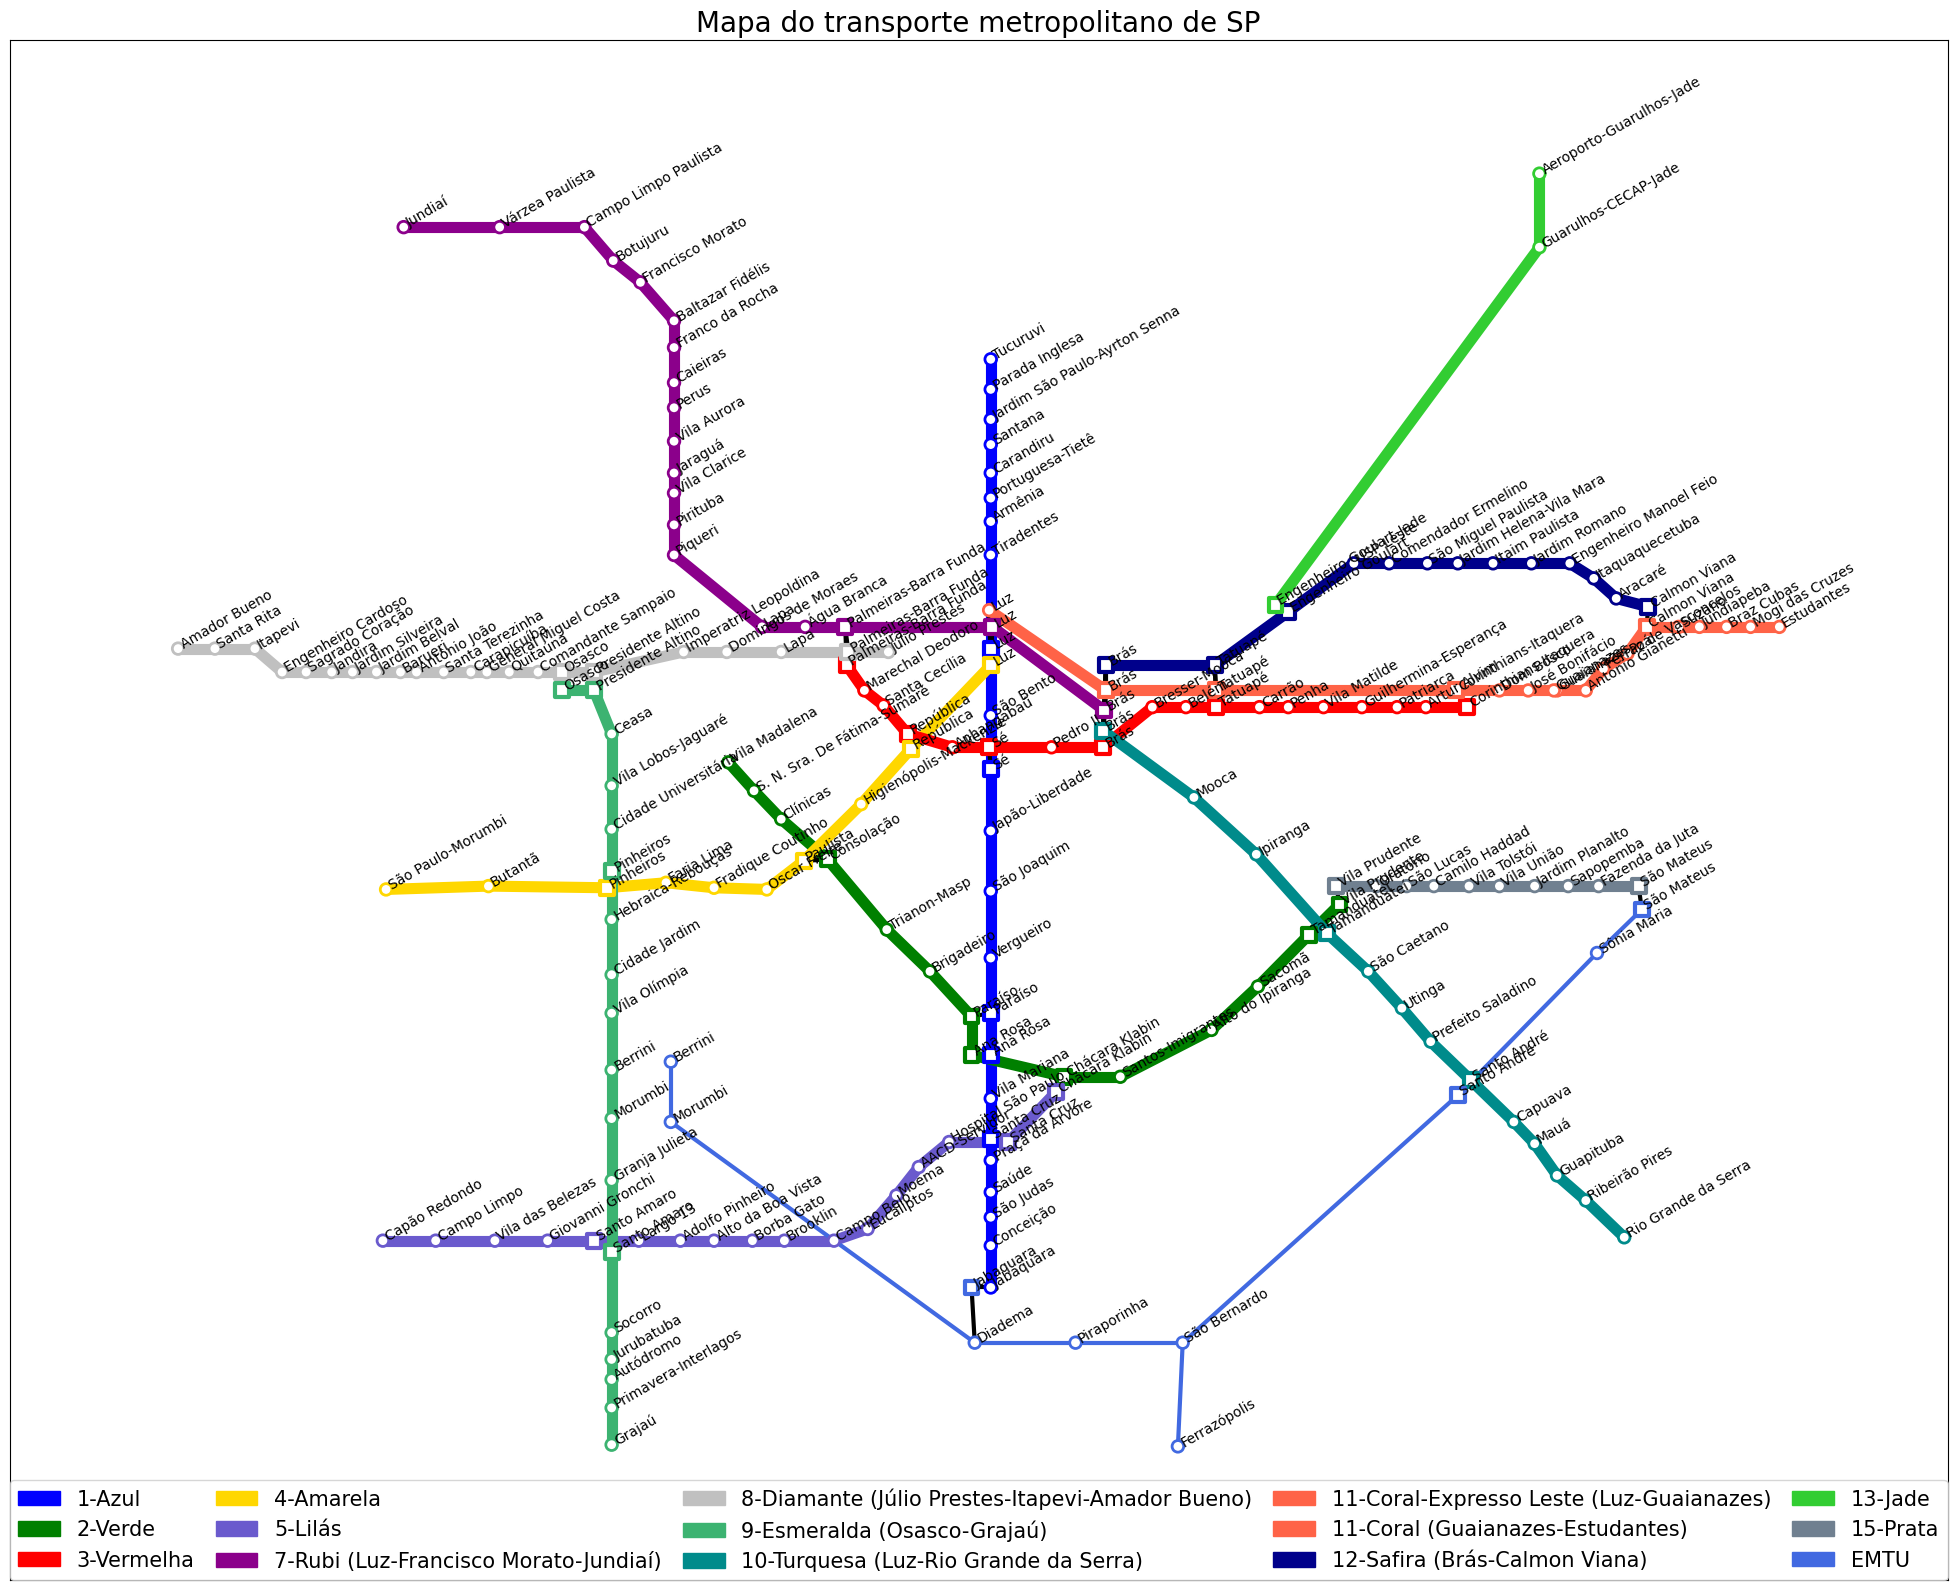


Escolha a opção abaixo no menu:
	1) Listar estações
	2) Definir viagem
	3) Visualizar mapa
	4) Sair
Programa encerrado


In [6]:
# Interface com o usuário
df_metro_sp = pd.read_csv('sp_transporte_ajustado.csv', delimiter=';') 
grafo_metro = construir_grafo_metro(df_metro_sp)

print('Bem vindo.')

while True:
    print('\nEscolha a opção abaixo no menu:')
    print('\t1) Listar estações')
    print('\t2) Definir viagem')
    print('\t3) Visualizar mapa')
    print('\t4) Sair')

    option = input('\nInforme a opção desejada.')
    
    while option not in ['1','2','3','4']:
        option = input('Opção inválida. Informe a opção desejada.')

    if option == '1':
        listar_todas_estacoes(grafo_metro)
    elif option == '2':
        origem = input('\nQual a estação de origem (id ou nome)? ')
        destino = input('Qual a estação de destino (id ou nome)? ')
        print()
        encontrar_melhor_caminho(grafo_metro, origem, destino)
        
    elif option == '3':
        exibir_grafo(grafo_metro)
    else:
        print('Programa encerrado')
        break